<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_3_2_Traffic_Monitoring_in_Bangladesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Object Detection


Object detection is a computer vision task that involves identifying and location objects in images or video

Challenges of Object detection
1. partial or incomplete image
2. Overlapping image



**Object Classification vs Object Detection**

**Object Classification**

Is labelling an entire image with a single class of primary object, it uses single output per image, task is right or wrong predictions of that single label

**Object Detection**

Identify, locate and label multiple objects within an image,
multiple possible outputs per image
More complex, must account for multiple aspects of prediction
 * Presence of objects
 * Class of each object
 * Location of each object in a bounding box


Object Detection Applications
1. Wildlife monitoring
2. Medical Imaging
3. Traffic Data used in self driving cars


**Object Detection Components**
1. Model Architecture
 * Focus on YOLO (You Only Look Once)
2. Pretrained models
 * Fixed architecture
 * Pretrained weights for common objects
3. Training Custom models
 * For custom classes
 * Need labeled data
 * Define loss function for the multiple parts of objects detection

### 3.2 Traffic Data as Images and Video

Working with image and video data for object detection. We'll explore the specific traffic dataset for this project. The focus will be on how video data can be converted to images, understanding bounding boxes for object classification, and using XML annotations to represent those bounding boxes.

**Objectives:**

* Load and organize the project dataset, separating images and their corresponding XML annotations.
* Extract frames from a video at regular intervals.
* Parse XML annotations.
* Visualize bounding boxes on image data.

### Setting Up

In [ ]:
import sys
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import pytubefix
from pytubefix import YouTube
from IPython.display import Video
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes, make_grid

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

 We are ready to start looking at the data. 🏎️💨

### Exploring Our Data

In this project, we'll work with two datasets. Let's start with the [Dhaka AI dataset](https://www.kaggle.com/datasets/rifat963/dhakaai-dhaka-based-traffic-detection-dataset), which contains images of vehicles in urban traffic scenes from Dhaka, Bangladesh. This dataset is particularly interesting for computer vision as it captures the unique characteristics of Dhaka's busy streets, including a diverse mix of vehicle types and dense traffic conditions.

We'll use the dataset for object detection which is a more complex task than image classification. Object detection identifies specific objects within an image (e.g., cars, buses, motorcycles), determines the precise location of these objects, and draws a bounding box around each detected object.

This dataset will be used in a later lesson to create a custom model. For now, we'll begin by exploring the dataset.

**Task 3.2.1:** Create a variable for the train directory using `pathlib` syntax.

In [ ]:
dhaka_image_dir = Path("data_images", "train")

print("Data directory:", dhaka_image_dir)

#output
Data directory: data_images/train


Let's examine some of the contents of the train directory. You'll see two types of files:

1. `.xml` files: These contain the annotations for the images.
2. `.jpg` files: These are the actual image files.

Each image typically has a corresponding XML file.

In [ ]:
dhaka_files = list(dhaka_image_dir.iterdir())
dhaka_files[-5:]

# Output
[PosixPath('data_images/train/Dipto_442.xml'),
 PosixPath('data_images/train/Numan_(56).jpg'),
 PosixPath('data_images/train/Navid_323.xml'),
 PosixPath('data_images/train/Navid_97.jpg'),
 PosixPath('data_images/train/Navid_181.jpg')]

Even though we only see one type of image file, it turns out that the image files can have many different possible extensions. Let's count the file extensions by type and print the results.

In [ ]:
file_extension_counts = Counter(Path(file).suffix for file in dhaka_files)

for extension, count in file_extension_counts.items():
    print(f"Files with extension {extension}: {count}")

# Output
Files with extension .xml: 3003
Files with extension .jpg: 2844
Files with extension .JPG: 143
Files with extension .png: 12
Files with extension .jpeg: 2
Files with extension .PNG: 2

### Separating images and bounding boxes data

Bounding boxes are rectangles around a detected object. All bounding box information is contained in the `.xml` files. The images have several different extensions.   It makes sense to separate the different file types into different folders. We'll want to put all `.xml` files in an annotations folder and the various image types in an images folder.

**Task 3.2.2:** Create variables for the images and annotations directories using `pathlib` syntax.

In [ ]:
images_dir = dhaka_image_dir / "images"
annotations_dir = dhaka_image_dir / "annotations"

images_dir.mkdir(exist_ok=True)
annotations_dir.mkdir(exist_ok=True)

**Task 3.2.3:** Move files to the appropriate directory based on file extensions.

In [ ]:
for file in dhaka_files:
    if file.suffix.lower() in (".jpg", ".jpeg", ".png"):
        target_dir = images_dir
    elif file.suffix.lower() == ".xml":
        target_dir = annotations_dir
    file.rename(target_dir / file.name)

Let's confirm that all the files where moved by making sure there is equal number of images and annotations.

In [ ]:
images_files = list(images_dir.iterdir())
annotations_files = list(annotations_dir.iterdir())

assert len(images_files) == len(annotations_files)

### Annotations

The annotations are the labels for the data. Each image has an annotation that contains the coordinates and type of object for each bounding box in a given image.

Let's look at the structure of the annotations by loading the first 25 lines of a file. The annotations are stored as XML which is a way to store structured documents. The `<annotation>` tag is the root element, containing all the information about this particular image annotation. The tags within store other information such as `<folder>`. The most important tag for the current project is the `<object>`. It describes an object detected in the image, this associated image contains a "bus". The tag `<bndbox>` is the bounding box information. There are the coordinates of a rectangle surrounding the bus in the image (in pixels): `<xmin>` is the left edge, `<ymin>` is the top edge, `<xmax>` is the right edge, and `<ymax>` is the bottom edge.

In [ ]:
xml_filepath = annotations_dir / "01.xml"
!head -n 25 $xml_filepath

#output
<annotation>
	<folder>Images</folder>
	<filename>02_Motijheel_280714_0005.jpg</filename>
	<path>E:\Datasets\Dataset\Images\02_Motijheel_280714_0005.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1200</width>
		<height>800</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bus</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>833</xmin>
			<ymin>390</ymin>
			<xmax>1087</xmax>
			<ymax>800</ymax>
		</bndbox>
	</object>

The ElementTree (ET) module in Python can parse an XML file. In XML, the root is the top-level element that contains all other elements. The `tag` attribute contains the name of the element.

In [ ]:
tree = ET.parse(xml_filepath)
root = tree.getroot()
print(root.tag)

The `find` method is used to locate the first occurrence of a sub-element with a given tag. Let's find the width and height of the image.

In [ ]:
width = int(root.find("size").find("width").text)
height = int(root.find("size").find("height").text)
print(f"image width: {width}  image height: {height}")

#output
image width: 1200  image height: 800


The `findall` method finds all occurrences of a sub-element within a given tag. We can use that method to get all the relevant data for the bounding boxes.

**Task 3.2.4:** Find the labels and coordinates for all the bounding boxes.

In [ ]:
bounding_boxes = []
labels = []
for obj in root.findall("object"):
    label = obj.find("name").text
    labels.append(label)
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])

for label, bounding_box in zip(labels, bounding_boxes):
    print(f"{label}: {bounding_box}")

#output

bus: [833, 390, 1087, 800]
bus: [901, 284, 1018, 395]
bus: [909, 241, 1010, 287]
rickshaw: [761, 413, 832, 540]
rickshaw: [777, 364, 828, 409]
rickshaw: [120, 351, 177, 423]
rickshaw: [178, 340, 245, 419]
rickshaw: [551, 229, 581, 267]
rickshaw: [849, 211, 870, 240]
rickshaw: [854, 191, 872, 208]
rickshaw: [395, 250, 437, 286]
rickshaw: [626, 209, 653, 240]
motorbike: [863, 241, 882, 268]
car: [218, 252, 289, 285]
car: [495, 216, 531, 244]
car: [485, 201, 520, 219]
three wheelers (CNG): [254, 347, 298, 418]
three wheelers (CNG): [398, 307, 457, 353]
three wheelers (CNG): [240, 290, 303, 344]
pickup: [933, 176, 959, 197]
three wheelers (CNG): [709, 188, 728, 207]
minivan: [575, 213, 600, 244]
car: [530, 212, 549, 237]
minivan: [592, 187, 633, 197]
suv: [616, 198, 654, 212]
suv: [879, 161, 918, 179]
minivan: [850, 151, 882, 166]
rickshaw: [844, 191, 856, 211]
van: [827, 174, 852, 194]
pickup: [410, 226, 452, 252]

### Bounding boxes in PyTorch

**Task 3.2.5:** Convert bounding boxes to PyTorch tensors.

In [ ]:
bboxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float)
print(bboxes_tensor)

#output
tensor([[ 833.,  390., 1087.,  800.],
        [ 901.,  284., 1018.,  395.],
        [ 909.,  241., 1010.,  287.],
        [ 761.,  413.,  832.,  540.],
        [ 777.,  364.,  828.,  409.],
        [ 120.,  351.,  177.,  423.],
        [ 178.,  340.,  245.,  419.],
        [ 551.,  229.,  581.,  267.],
        [ 849.,  211.,  870.,  240.],
        [ 854.,  191.,  872.,  208.],
        [ 395.,  250.,  437.,  286.],
        [ 626.,  209.,  653.,  240.],
        [ 863.,  241.,  882.,  268.],
        [ 218.,  252.,  289.,  285.],
        [ 495.,  216.,  531.,  244.],
        [ 485.,  201.,  520.,  219.],
        [ 254.,  347.,  298.,  418.],
        [ 398.,  307.,  457.,  353.],
        [ 240.,  290.,  303.,  344.],
        [ 933.,  176.,  959.,  197.],
        [ 709.,  188.,  728.,  207.],
        [ 575.,  213.,  600.,  244.],
        [ 530.,  212.,  549.,  237.],
        [ 592.,  187.,  633.,  197.],
        [ 616.,  198.,  654.,  212.],
        [ 879.,  161.,  918.,  179.],
        [ 850.,  151.,  882.,  166.],
        [ 844.,  191.,  856.,  211.],
        [ 827.,  174.,  852.,  194.],
        [ 410.,  226.,  452.,  252.]])

**Task 3.2.6:** Create a variable for the image path using `pathlib` syntax.

In [ ]:
image_path = images_dir / "01.jpg"
image = read_image(str(image_path))
print(image.shape)

#output
torch.Size([3, 800, 1200])


We can use the `draw_bounding_boxes` function to add the bounding boxes and labels to the image.

In [ ]:
image = draw_bounding_boxes(
    image=image,
    boxes=bboxes_tensor,
    labels=labels,
    width=3,
    fill=False,
    font="arial.ttf",
    font_size=10,
)

**Task 3.2.7:** Display the composite image with bounding boxes and labels.

In [ ]:
to_pil_image(image)

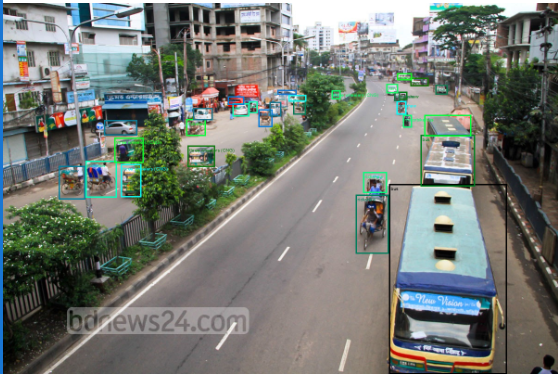



### YouTube Video Data

Next, we load YouTube video of traffic in Dhaka, Bangladesh.

**Task 3.2.8:** Create a variable for the video directory using `pathlib` syntax.

In [ ]:
video_dir = Path("data_video")
video_name = "dhaka_traffic.mp4"
video_path = video_dir / video_name

print(video_path)

#output
data_video/dhaka_traffic.mp4


We need to specify the URL of the YouTube video and download the video

In [ ]:
video_url = "https://www.youtube.com/watch?v=0035050509558"
yt = YouTube(video_url)
stream = yt.streams.get_highest_resolution()
stream.download(output_path=video_dir, filename=video_name)

We don't need to download the video ourselve as,
The video is already available in the correct location. Let's look at the video.

In [ ]:
Video(video_path, embed=True)

We are going to capture still images from the video to make it easier to draw bounding boxes.

In [ ]:
video_capture = cv2.VideoCapture(video_path)

if not video_capture.isOpened():
    print("Error: Could not open video.")
else:
    frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Frame rate: {frame_rate}")
    print(f"Total number of frames: {frame_count:,}")


#output
Frame rate: 25.0
Total number of frames: 9,333

Let's look the first frame.

In [ ]:
success, first_frame = video_capture.read()
if success:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read frame.")

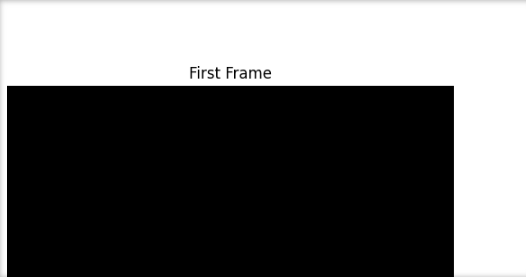

We were successful in displaying the first frame, however that frame is black. Let's look at a later frame that is more interesting.

In [ ]:
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 100)
success, later_frame = video_capture.read()
if success:
    plt.imshow(cv2.cvtColor(later_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame")
    plt.axis("off")
    plt.show()
else:
    print("Error: Could not read frame.")

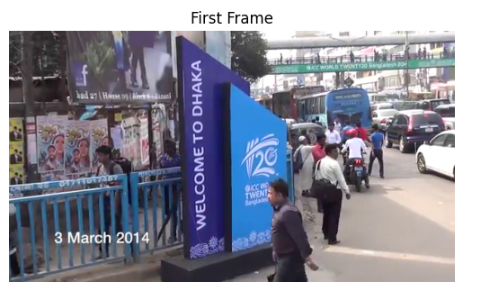

**Task 3.2.9:** Create a directory for the frames using the `pathlib` syntax.

In [ ]:
frames_dir = video_dir / "extracted_frames"
frames_dir.mkdir(exist_ok=True)

Now we walk through the video, saving selected frames as we go.

In [ ]:
frame_count = 0

while True:
    success, frame = video_capture.read()
    if not success:
        break

    # Save frames at the frame_rate
    if frame_count % frame_rate == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)

    frame_count += 1

video_capture.release()

We can look at the frames we have extracted and saved using the `display_sample_images` function.

In [ ]:
def display_sample_images(dir_path, sample=5):
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_images = images[:sample]
        for sample_image in sample_images:
            image = read_image(str(sample_image))
            resize_transform = transforms.Resize((240, 240))
            image = resize_transform(image)
            image_list.append(image)
    grid = make_grid(image_list, nrow=5)
    image = to_pil_image(grid)
    return image


display_sample_images(frames_dir, sample=10)

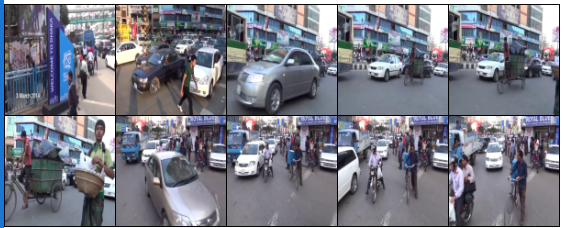